In [1]:
import torch
import torch.functional as F
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from torchviz import make_dot
from IPython.display import HTML
from tqdm import tqdm
%matplotlib inline

In [2]:
# strength and range parameter of potential
eps,sig = 1.0,1.5

In [3]:
def Ulj(rs):
    f6 = (sig / rs) ** 6
    return 4*eps*(f6*f6  - f6)

In [4]:
base = torch.linspace(0.0, 4*sig,1000, requires_grad=True)
xs = base / sig
ps = Ulj(xs)/eps
loss = ps.sum()
loss.backward()
dps = base.grad / eps

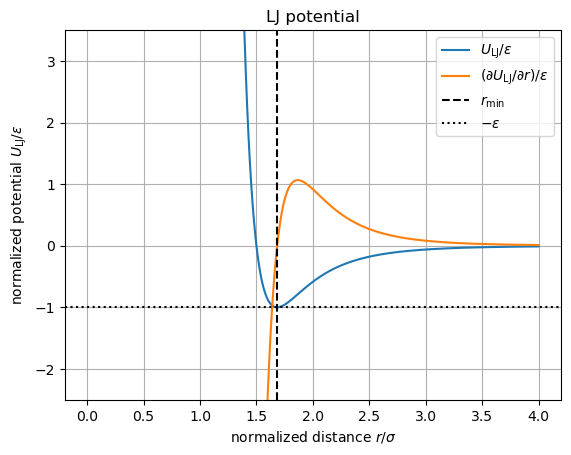

In [5]:
with torch.no_grad():
    plt.plot(xs,ps,label="$U_\\mathrm{LJ}/\\varepsilon$")
    plt.plot(xs,dps,label="$(\\partial U_\\mathrm{LJ}/\\partial r)/\\varepsilon$")
plt.ylim(-2.5,3.5)
plt.grid(True)
plt.title("LJ potential")
plt.xlabel("normalized distance $r/\\sigma$")
plt.ylabel("normalized potential $U_\\mathrm{LJ}/\\varepsilon$")
r_min = (2 ** (1/6)) * sig
plt.axvline(r_min, color="k", linestyle="--", label="$r_\\mathrm{min}$")
plt.axhline(-eps, color="k", linestyle=":", label="$-\\varepsilon$")
plt.legend()

### Calculating forces

Calculate the force between two particles at positions $r_1$ and $r_2$ like this: $\text{F}=-\frac{\partial U_\text{LJ}}{\partial r}$ where $r$ is the euclidean distance between the two particles.

In [82]:
dt = 1e-3
epochs, subepochs = 100, 5
total_epochs = epochs*subepochs
m = 1.0 # particle mass

In [83]:
# world specification
world_min, world_max = 3.5*torch.tensor([[-1.0,-1.0],[1.0,1.0]])

In [94]:
# define walls
nparts = 5
line_start,line_end = torch.tensor([[world_min[0],world_max[1]],[world_max[0],world_max[1]]])
static_rs = torch.zeros((nparts, 2))
for idx in range(nparts):
    t = idx / (nparts - 1)
    static_rs = line_start + (line_end - line_start)*t

In [95]:
rs = torch.tensor([[-1.0,0.0],[1.0,0.0],[0.0,-1.0],[0.0,1.0]], requires_grad=True)
vs = torch.tensor([[10.0*sig,0.0],[-10.0*sig,0.0],[0.0,5.0*sig],[0.0,-5.0*sig]])
rs,vs

(tensor([[-1.,  0.],
         [ 1.,  0.],
         [ 0., -1.],
         [ 0.,  1.]], requires_grad=True),
 tensor([[ 15.0000,   0.0000],
         [-15.0000,   0.0000],
         [  0.0000,   7.5000],
         [  0.0000,  -7.5000]]))

In [96]:
# pairwise distances
dr = rs[None,:,:]-rs[:,None,:]

In [97]:
# how to evaluate potential at each point
grid_x,grid_y = (
    torch.linspace(world_min[0], world_max[0], steps=100), 
    torch.linspace(world_min[1], world_max[1], steps=100),
)
grid_points = torch.cartesian_prod(*(grid_x,grid_y))
allpots = lambda: (
    Ulj(F.norm(rs[None,:,:]-grid_points[:,None,:], p=2.0, dim=-1))
    .sum(dim=-1)
    .reshape(len(grid_x),len(grid_y))
)

In [98]:
K = lambda v: 0.5*m*(F.norm(v, p=2.0, dim=1)**2)

with torch.no_grad():
    dists = F.norm(rs[None,:,:] - rs[:,None,:], dim=-1)
    Ks,Us = [K(vs).sum()], [Ulj(F.norm(dists, p=2.0)).item()]
    trajs = [(rs.clone(), vs.clone(), dists.clone())]
    potss = [allpots()]

100%|██████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 586.31it/s]


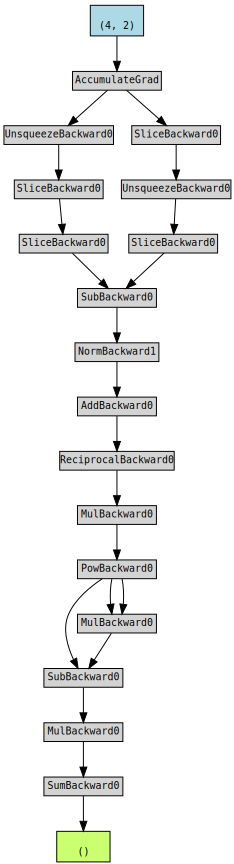

In [99]:
for epoch in tqdm(range(epochs)):
    for _ in range(subepochs):
        # calculate potential
        dr = rs[None,:,:] - rs[:,None,:]
        dists = F.norm(dr, dim=-1)
        # set diagonal distance entries to inf to make potential 0
        dists = dists + torch.diag(torch.inf * torch.ones(len(rs)))
        pot = Ulj(dists)
        potsum = pot.sum()
        
        # clear gradients and calc derivative
        rs.grad = None
        potsum.backward()
        # update particles
        with torch.no_grad():
            pot_F = -rs.grad
            a = pot_F/m
            
            # TODO: velocity verlet
            vs += dt*a
            rs += dt*vs# + 0.5*a1*(dt**2)
    with torch.no_grad():
        trajs.append((rs.clone(),vs.clone(),dists.clone()))
        Ks.append(K(vs).sum())
        Us.append(potsum.item())
        potss.append(allpots())
make_dot(potsum)

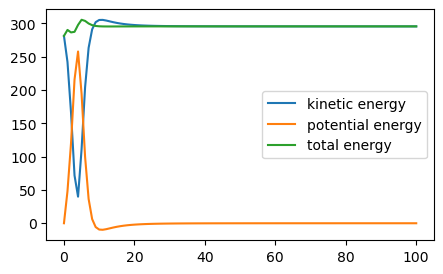

In [100]:
# show hockeystick diagram
fig,ax = plt.subplots(sharex=True,figsize=(5,3))
ax.plot(Ks, label="kinetic energy")
ax.plot(Us, label="potential energy")
ax.plot(torch.tensor(Ks)+torch.tensor(Us), label="total energy")
ax.legend()

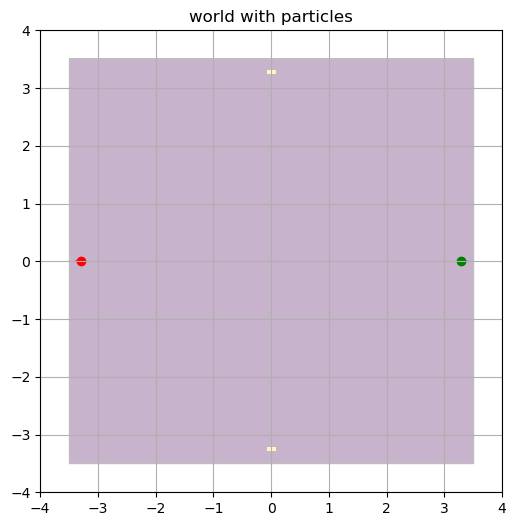

In [101]:
arrow_params = lambda c: dict(head_width=0.05, head_length=0.1, fc=c, ec=c, animated=True)

fig,ax = plt.subplots(figsize=(6,6))

# plot organization
ax.set_title("world with particles")
ax.grid(True)

# show virtual world borders
ax.set_xlim(world_min[0]-.5,world_max[0]+.5)
ax.set_ylim(world_min[1]-.5,world_max[1]+.5)
ax.add_patch(plt.Rectangle(world_min, *(world_max - world_min), fc="none", ec=".75"))

# store trajectory images
frames = []
for (r,v,_),pots in zip(trajs,potss):
    elems = [ax.imshow(pots, alpha=0.3, extent=(world_min[0],world_max[0],world_min[1],world_max[1]))]
    for i,c in enumerate(list("rgby")):
        elems += [
            ax.scatter(*r[i], label=f"p{i}", color=c, animated=True),
            ax.arrow(*r[i], *dt*v[i], label=f"p{i}'s speed vector", **arrow_params(c)),
        ]
    frames.append(elems)
ani = animation.ArtistAnimation(fig, frames, interval=100, blit=True, repeat_delay=1500)
HTML(ani.to_html5_video())